In [1]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon, box

In [2]:
import numpy as np

# get grids

In [3]:
cityline = gp.read_file('data/open-baltimore/raw/Baltcity_20Line/baltcity_line.shp')
cityline = cityline.to_crs(epsg=3559)

In [4]:
def get_grids(shape, grid_size=200, return_gpdf=True):
    from shapely.geometry import Polygon, LineString
    do_intersect = False
    
    if isinstance(shape, tuple):
        if len(shape)==4:
            lon_min, lat_min, lon_max, lat_max = shape
        else:
            print('shape is a tuple, but its len != 4')
    elif isinstance(shape, LineString):
        if shape.is_closed:
            lon_min, lat_min, lon_max, lat_max = shape.bounds
            shape = Polygon(shape)
            do_intersect = True
        else:
            print('shape is LineString but not closed, which is not supported here')
    elif isinstance(shape, Polygon):
        lon_min, lat_min, lon_max, lat_max = shape.bounds
        do_intersect = True
    else:
        print('shape is not bbox tuple, closed LineString or Polygon')
        
    grid_lon, grid_lat = np.mgrid[lon_min:lon_max:grid_size, lat_min:lat_max:grid_size]
    grids_poly = []
    for j in range(grid_lat.shape[1]-1):
        for i in range(grid_lon.shape[0]-1):
            g = box(grid_lon[i,j], grid_lat[i,j], grid_lon[i+1,j+1], grid_lat[i+1,j+1])
            if do_intersect and not g.intersects(shape):
                continue
            grids_poly.append(g)
            
    if return_gpdf:
        return gp.GeoDataFrame(grids_poly).rename(columns={0: 'geometry'})
    return grids_poly

In [5]:
grid_size=200
grids = get_grids(cityline.geometry[0], grid_size)
print(grids.shape)
grids.plot()

(5991, 1)


In [6]:
grids['centroid'] = grids.geometry.apply(lambda x: x.centroid)

In [7]:
grids['cx'] = grids.centroid.apply(lambda x: x.coords[0][0])
grids['cy'] = grids.centroid.apply(lambda x: x.coords[0][1])

In [8]:
grids_cxcy = np.vstack([grids['cx'], grids['cy']]).T

# crime data

In [42]:
crimes_df = pd.read_csv('data/open-baltimore/raw/BPD_Part_1_Victim_Based_Crime_Data.csv')
crimes_df['geometry'] = crimes_df.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)

In [43]:
crimes_4326 = gp.GeoDataFrame(crimes_df[~crimes_df.Longitude.isnull()][['geometry', 'CrimeDate', 'CrimeTime', 'CrimeCode', 'Weapon']])
crimes_4326.crs = {'init': 'epsg:4326'}

In [44]:
crimes = crimes_4326.to_crs(epsg=3559)

In [45]:
crimes['lon'] = crimes.geometry.apply(lambda x: x.coords[0][0])
crimes['lat'] = crimes.geometry.apply(lambda x: x.coords[0][1])
crimes['lonlat'] = crimes.geometry.apply(lambda x: list(x.coords[0]))

In [46]:
crimes['CrimeDate'] = pd.to_datetime(crimes['CrimeDate'], format='%m/%d/%Y')

In [47]:
crimes = crimes.reset_index().set_index('CrimeDate').sort_index()

In [60]:
dates = crimes.index.unique()

# KDE

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [64]:
time_window = 60

In [65]:
test_date = dates[100]
train_end_date=test_date - pd.Timedelta(days=1)
train_start_date =test_date - pd.Timedelta(days=time_window+1)

In [66]:
crimes_slice = crimes.loc[train_start_date: train_end_date]

In [68]:
X = np.vstack([crimes_slice.lon.values, crimes_slice.lat.values]).T

In [ ]:
search = GridSearchCV(KernelDensity(), 
                      {'bandwidth': np.linspace(100, 1000, 10)},
                    cv=10) # 20-fold cross-validation
search.fit(X)
print (search.best_params_)


In [ ]:
kde = search.best_estimator_

In [ ]:
pdf = np.exp(kde.score_samples(grids_cxcy))


In [96]:
pdf_gpdf = gp.GeoDataFrame(np.vstack([grid_x1.ravel(), grid_x2.ravel(), pdf]).T)

In [97]:
pdf_gpdf.columns=['x1','x2', 'density']

In [98]:
pdf_gpdf['geometry'] = pdf_gpdf.apply(lambda x: Point(x.x1, x.x2), axis=1)

In [99]:
%matplotlib inline

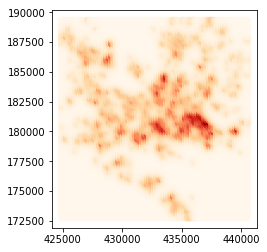

In [140]:
pdf_gpdf.plot(column='density', cmap='OrRd')

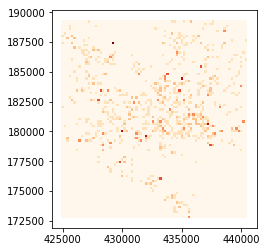

In [139]:
grids_poly_gpdf.join(join.groupby('index_right').count()[['x1']]).fillna(0).plot(column='x1', cmap='OrRd')

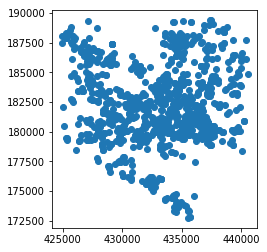

In [82]:
crimes_3559_slice.plot()